In [23]:
import time

# machine learning classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# For data manipulation
import pandas as pd
import numpy as np

# To plot
import matplotlib.pyplot as plt

# Poloniex
from poloniex import Poloniex
polo = Poloniex()

### Fetch Data

A function that returns a pandas dataframe of historical market data from Poloniex.

In [16]:
def loadPolo(pair, period, start, end):
    raw = polo.returnChartData(currencyPair=pair,period=period,start=start,end=end)
    dates = []
    df={ col:[]  for col in list(raw[0].keys()) }
    for i in range(len(raw)):  
        dates.append(int(raw[i]['date']))
        for col in list( raw[0].keys()):
            df[col].append( float( raw[i][col] ) )
    df.pop('date')
    return pd.DataFrame( df, index=pd.to_datetime(dates,unit='s'))

### Process Data

This function returns a data set and target values.

The data consists of open, close, high, and low columns. The columns are normalized by the weightedAverage, then rescaled logarithmically, then linearly scaled so values are roughly between 1 and -1.

The target values are plus/minus 1 depending on the sign of the change in weightedAverage.

In [17]:
def processDf(df):
    return [ 100 * np.log( np.array(df[['open','close','high','low']].div(df.weightedAverage,axis=0))[:-1]),
        np.array([ (1 if df.weightedAverage.iloc[i] < df.weightedAverage.iloc[i+1] else -1) for i in range(len(df)-1)]) ]

### Base Data

For our base data we use the pair USDT_BTC.

In [18]:
pair='USDT_BTC'
period=14400 # 4 hours
length=5000
end = time.time() # Now
start = end - ( length * period ) # A long time ago...

df=loadPolo(pair,period,start,end)
X,y = processDf(df)

### Optimize Parameters

We use the function GridSearchCV to find decent parameters for our model.

In [19]:
%%time
clf = GridSearchCV(
        SVC(),
        {
            'kernel':('linear', 'rbf'), 
            'C':[120, 100,80], 
            'gamma':[0.05, 0.001,0.005]
        }, 
        refit=True
    ).fit(X,y)
print('Best accuracy: {:.2f}% at {}'.format( 100*clf.best_score_, clf.best_params_ ))

Best accuracy: 67.70% at {'gamma': 0.001, 'kernel': 'rbf', 'C': 100}
CPU times: user 2min 1s, sys: 824 ms, total: 2min 2s
Wall time: 2min 2s


### Test Model Against Strange

We test the model generated by our base data and optimized parameters against various trading pairs 

In [20]:
pairs = [
    'USDT_BCH',
    'USDT_BTC',
    'USDT_DASH',
    'USDT_ETC',
    'USDT_ETH',
    'USDT_LTC',
    'USDT_NXT',
    'USDT_REP',
    'USDT_STR',
    'USDT_XMR',
    'USDT_XRP',
    'USDT_ZEC',
    'BTC_ETH',
    'BTC_XRP',
    'BTC_DASH',
    'BTC_LTC'
]
for pair in pairs:
    score = clf.best_estimator_.score( *processDf( loadPolo(pair,period,start,end) ) ) 
    print( '{:.2f}% for {}'.format(100*score,pair) )

68.50% for USDT_BCH
68.08% for USDT_BTC
64.44% for USDT_DASH
66.76% for USDT_ETC
68.60% for USDT_ETH
65.34% for USDT_LTC
60.40% for USDT_NXT
66.32% for USDT_REP
57.41% for USDT_STR
65.72% for USDT_XMR
61.12% for USDT_XRP
67.66% for USDT_ZEC
69.28% for BTC_ETH
63.40% for BTC_XRP
67.94% for BTC_DASH
63.90% for BTC_LTC


### Backtest

We use the same old function to get the value of a portfolio over time. The total includes compounded returns and approximate trading fee. 

In [21]:
def getValues(price,signal):
    value = 1.0
    values = []
    dates = []
    paid = False
    for i, sig in signal.iteritems():
        if sig and not paid:
            paid = price[i]
        elif not sig and paid:
            value *= price[i] / paid
            value *= 0.9975 * 0.9975
            paid = False
        values.append(value)
        dates.append(i)
    return pd.Series(values,index=dates)

### Backtest on ETH

After we load and format data for the pair USDT_ETH, we compute baseVal and predictVal. The baseVal is the value computed using the base target as signal so this would be "perfect" trading. The predictVal is the value computed using the signal predicted by our model. We use the weightedAverage for all prices. We use a logarithmic scale because our minds can't comprehend otherwise.

Honestly I think there's a bug somewhere because the returns are LOCO. Something like \$1 -> \$485,165,195

/home/ahab/Projects/backtest/backtest_env/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


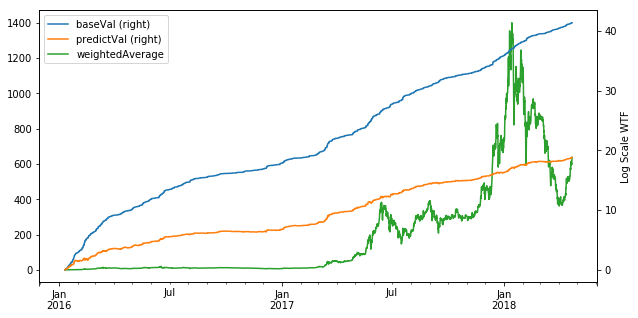

In [25]:
#Load data
ethdf = loadPolo('USDT_ETH',period,start,end)
eX,ey = processDf(ethdf)

# Reformat data
ethdf = ethdf[:-1]
ethdf['base'] = (ey + 1) / 2
ethdf['predict'] = (clf.best_estimator_.predict(eX) + 1) / 2

# Get values
ethdf['baseVal'] = np.log(getValues(ethdf['weightedAverage'],ethdf['base']))
ethdf['predictVal'] = np.log(getValues(ethdf['weightedAverage'],ethdf['predict']))

#Plot values
ethdf.plot(y=['baseVal','predictVal','weightedAverage'],secondary_y=['baseVal','predictVal'],figsize=(10,5))
plt.ylabel("Log Scale WTF")
plt.show()

### Graphing All Pairs

USDT_BCH


/home/ahab/Projects/backtest/backtest_env/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


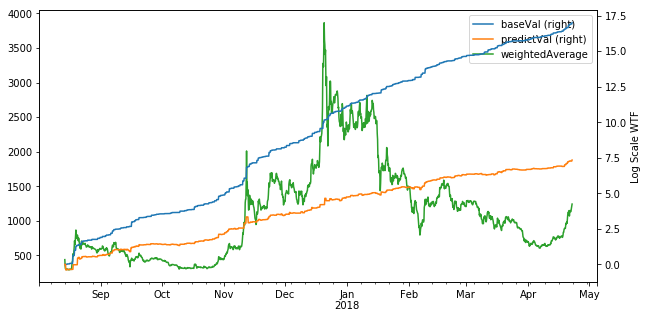

USDT_BTC


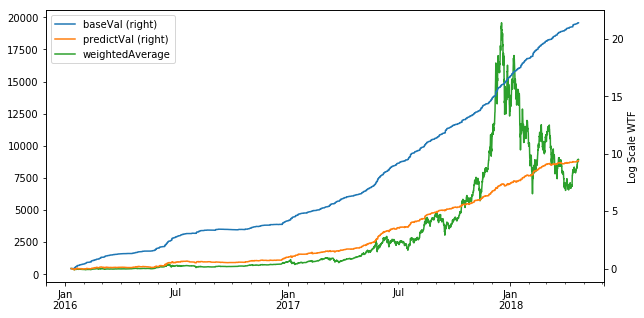

USDT_DASH


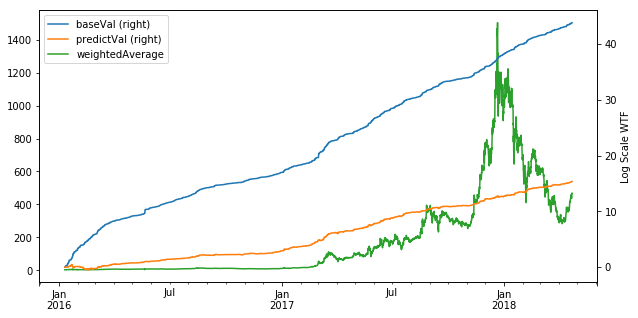

USDT_ETC


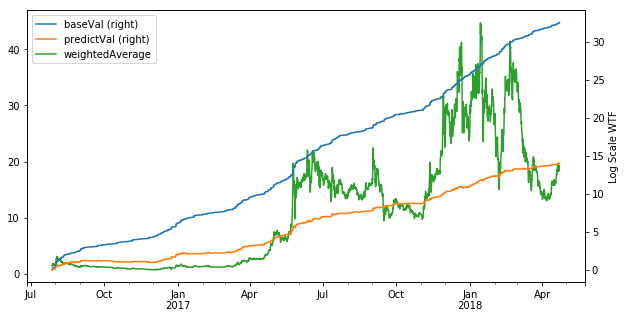

USDT_ETH


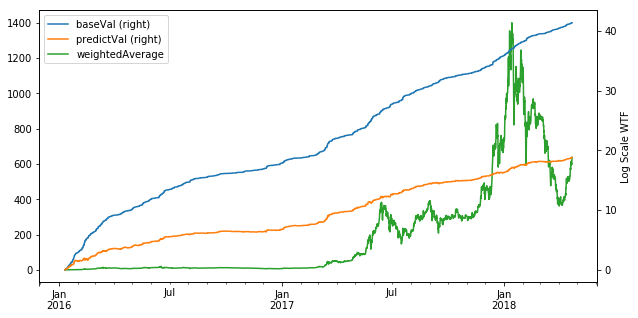

USDT_LTC


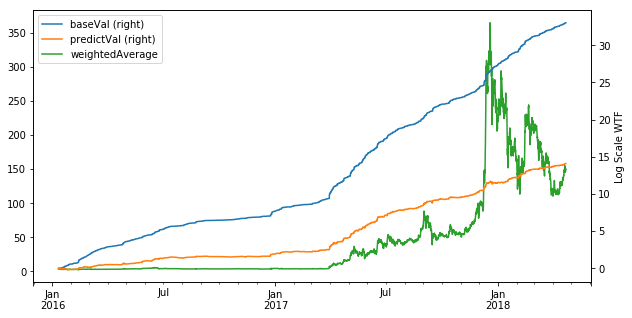

USDT_NXT


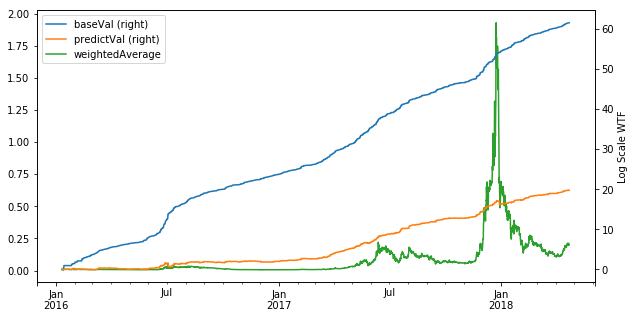

USDT_REP


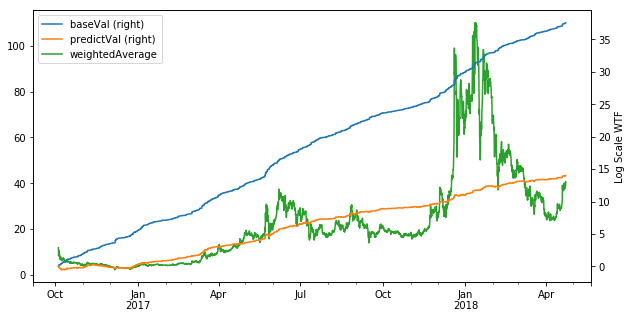

USDT_STR


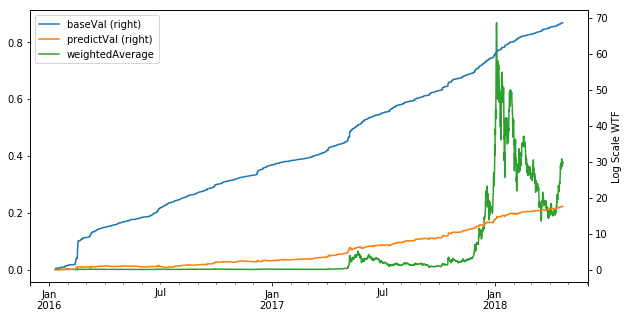

USDT_XMR


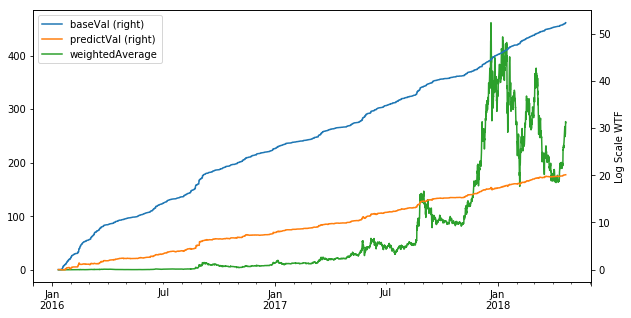

USDT_XRP


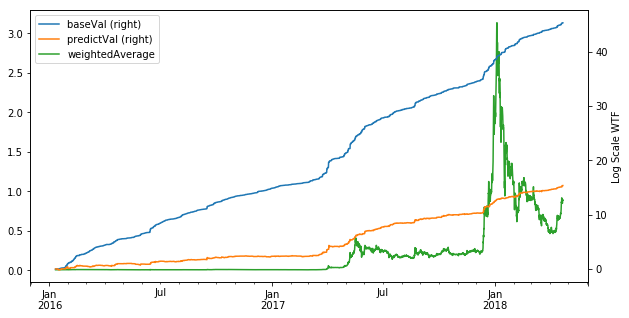

USDT_ZEC


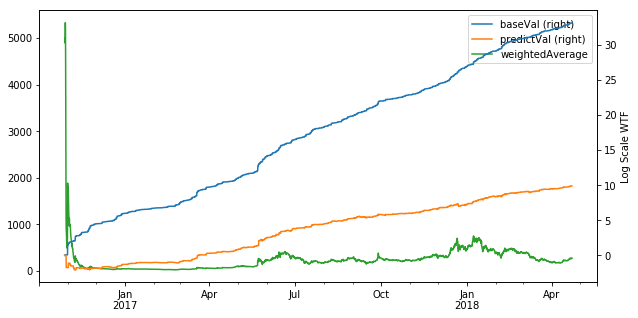

BTC_ETH


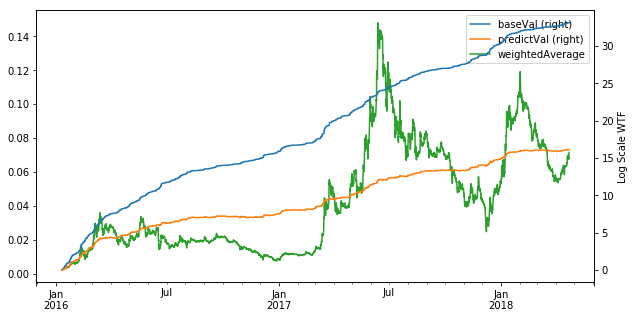

BTC_XRP


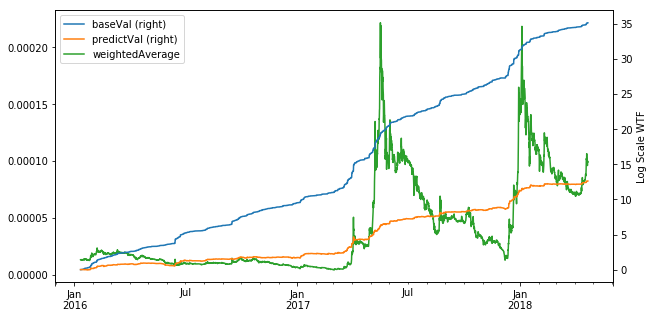

BTC_DASH


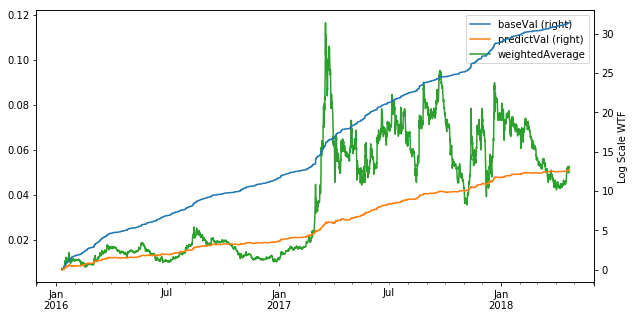

BTC_LTC


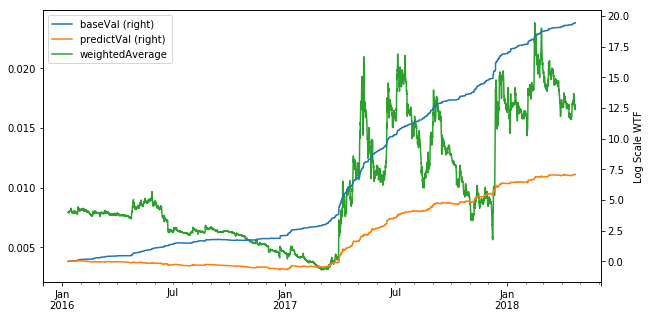

In [28]:
def graphPair(pair):
    #Load data
    ethdf = loadPolo(pair,period,start,end)
    eX,ey = processDf(ethdf)

    # Reformat data
    ethdf = ethdf[:-1]
    ethdf['base'] = (ey + 1) / 2
    ethdf['predict'] = (clf.best_estimator_.predict(eX) + 1) / 2

    # Get values
    ethdf['baseVal'] = np.log(getValues(ethdf['weightedAverage'],ethdf['base']))
    ethdf['predictVal'] = np.log(getValues(ethdf['weightedAverage'],ethdf['predict']))

    #Plot values
    ethdf.plot(y=['baseVal','predictVal','weightedAverage'],secondary_y=['baseVal','predictVal'],figsize=(10,5))
    plt.ylabel("Log Scale WTF")
    plt.show()
    
for pair in pairs:
    print(pair)
    graphPair(pair)